In [88]:
from augur.io import read_metadata
from Bio import SeqIO
import cv2
import jellyfish
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [70]:
def sample_population_pairs_by_year(metadata, size):
    """Given a metadata data frame with a "year" column,
    randomly select a year and then randomly subsample
    two pairs of populations of the same size from that year.
    Returns a tuple of tuples of strain names.
    """
    year = np.random.choice(metadata["year"].drop_duplicates().values)
    sample_1 = metadata[metadata["year"] == year].sample(n=size, replace=True).index.values
    sample_2 = metadata[metadata["year"] == year].sample(n=size, replace=True).index.values
    
    return sample_1, sample_2

In [11]:
def hamming_distance(sequence_a, sequence_b):
    """Light-weight wrapper around a fast Hamming distance calculation."""
    return jellyfish.hamming_distance(
        sequence_a,
        sequence_b
    )

In [52]:
metadata = read_metadata("filtered_metadata.tsv")

In [67]:
metadata.head()

,generation,fitness,num_date,date,year,month
strain,,,,,,
sample_10000_79,10000,0.139349,2050.0,2050-01-01,2050,1
sample_10000_94,10000,0.152067,2050.0,2050-01-01,2050,1
sample_10000_19,10000,0.166518,2050.0,2050-01-01,2050,1
sample_10000_38,10000,0.148693,2050.0,2050-01-01,2050,1
sample_10000_49,10000,0.141225,2050.0,2050-01-01,2050,1


In [104]:
metadata.groupby("year")["date"].count()

year
2010    240
2011    240
2012    240
2013    240
2014    240
2015    240
2016    240
2017    240
2018    240
2019    240
2020    240
2021    240
2022    240
2023    240
2024    240
2025    240
2026    240
2027    240
2028    240
2029    240
2030    240
2031    240
2032    240
2033    240
2034    240
2035    240
2036    240
2037    240
2038    240
2039    240
2040    240
2041    240
2042    240
2043    240
2044    240
2045    240
2046    240
2047    240
2048    240
2049    240
2050     20
Name: date, dtype: int64

In [64]:
sequences_by_name = {
    record.name: str(record.seq)
    for record in SeqIO.parse("aa_sequence.HA.fasta", "fasta")
}

In [66]:
sequences_by_name["sample_2000_84"]

'MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTLVKTISNDQIEATNASELVQSSSTGRICETPHRILDGKNCTLIDALLGDPHCDGFQNKEWDLFVDRSKAYSNCYPYEVPDYASLRSLAASSGTLEFVNEDFNWTGVAQDGGSYACKRGSLNSFFSRLNWLHRSEYKYSALNVTMLNNGRFDKLYIWGVHHPSTDKDQTSLYVRASGRVTVSTKRSQQTVTPNIGSRPWVRGQTSRISIYWTIVKQGDILLINSTGNLIAPRGYFKIRNGKSSIMKSDAPIGTCSSECITPNGSIPNDKIFQNVNRITYGACPSYVKQNTLKLATGMRNVPEKQTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGTGQAADLKSTQAAIDQINGKLNRLIEKTNEKFHQIEKEFSEVEGRIQDLEKYVEDTKIDLWSYNAELLVAAENQHTIDLTDSEMNRLFEKTRKQLRENAEDMGNGCFKIYHKCDNACIGSIRNGTYDHDVYRDEALNNRFQIKGVELKSGYKDWILWISFAISCFLLCVVLLGFIMWACQKGNIRCNICI'

In [132]:
distances = []
for i in range(200):
    sample_a, sample_b = sample_population_pairs_by_year(metadata, 60)
    sequences_a = [sequences_by_name[name] for name in sample_a]
    sequences_b = [sequences_by_name[name] for name in sample_b]

    sample_a_frequencies = (np.ones((len(sequences_a), 1)) / len(sequences_a)).reshape(-1, 1).astype(np.float32)
    sample_b_frequencies = (np.ones((len(sequences_b), 1)) / len(sequences_b)).reshape(-1, 1).astype(np.float32)

    distance_matrix = np.zeros((len(sequences_a), len(sequences_b)))
    for i, sequence_a in enumerate(sequences_a):
        for j, sequence_b in enumerate(sequences_b):
            distance_matrix[i, j] = hamming_distance(sequence_a, sequence_b)

    distance_matrix = distance_matrix.astype(np.float32)

    emd, _, model_flow = cv2.EMD(
        sample_a_frequencies,
        sample_b_frequencies,
        cv2.DIST_USER,
        cost=distance_matrix
    )
    distances.append(emd)

In [133]:
bins = np.arange(0, int(np.ceil(max(distances))) + 1, 0.5)

In [134]:
bins

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5])

In [135]:
min(distances)

2.466667413711548

In [136]:
max(distances)

5.966668605804443

In [137]:
np.mean(distances)

4.249251470565796

In [138]:
np.median(distances)

4.283334732055664

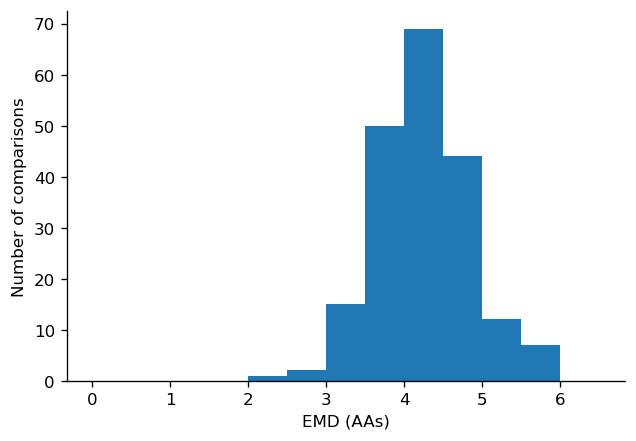

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=120)
ax.hist(
    distances,
    bins=bins,
)
ax.set_xlabel("EMD (AAs)")
ax.set_ylabel("Number of comparisons")

sns.despine()